In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
import glob
import uncertainties.unumpy as unp
import uncertainties as unc

folder_N = glob.glob('./calibration_measurements_hbn/Nikon/*.txt')
folder_A = glob.glob('./calibration_measurements_hbn/AFM/*.txt')

data_N = np.array([])
data_A = np.array([])
for file1 in folder_N:
    for file2 in folder_A:
        if file1[-22:-4]==file2[-22:-4]:
            data_N = np.append(data_N, np.loadtxt(file1, skiprows=3, usecols=(1, 2)))
            data_A = np.append(data_A, np.loadtxt(file2, skiprows=1, usecols=(0, 1)))

In [3]:
drs = data_N[::2]
sys_drs = 0.07
sd_drs = data_N[1::2]+sys_drs
thickness = data_A[::2]
sys_thickness = 0.8
sd_thickness = data_A[1::2]+sys_thickness

In [4]:
# define refractive index of hBN (https://onlinelibrary.wiley.com/doi/10.1002/pssb.201800417)
# wavelength in nm
def n_hbn(wvl):
    a = 3.263
    b = 164.4
    return np.sqrt(1+a*wvl**2/(wvl**2-b**2))


# plot without fit
plt.style.use('seaborn-whitegrid')
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.frameon"] = True

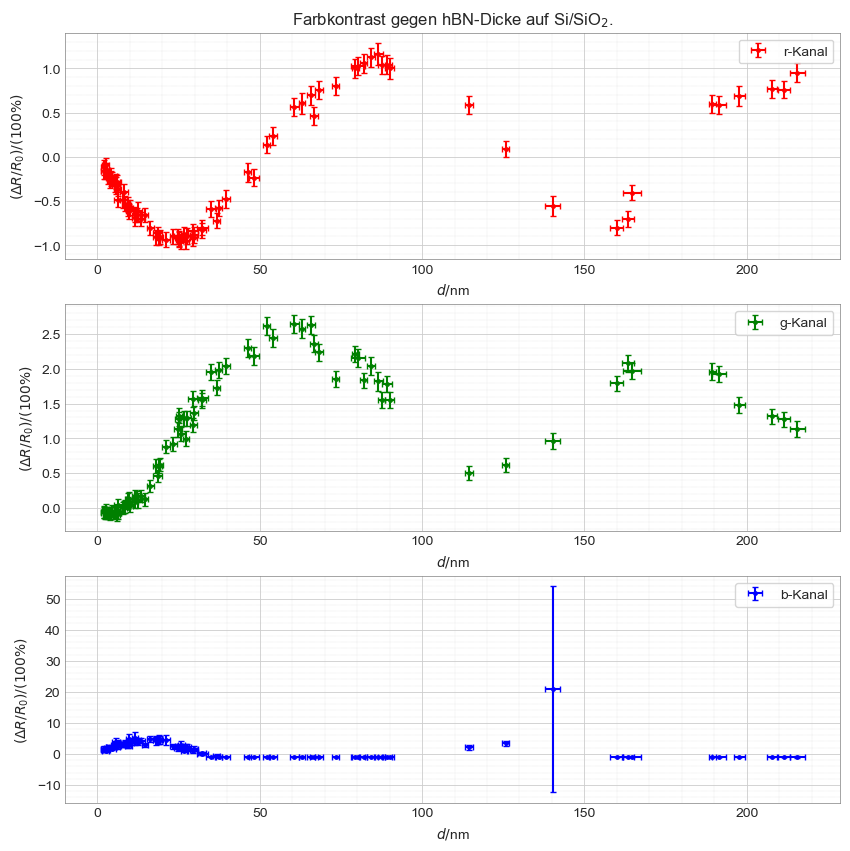

In [17]:
# plot without fit
plt.style.use('seaborn-whitegrid')
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.frameon"] = True
fig, ax = plt.subplots(3, figsize=(10, 10))

colors = ['r', 'g', 'b']
for i in range(3):
    ax[i].errorbar(thickness, drs[i::3], xerr=sd_thickness, yerr=sd_drs[i::3], capsize=2, fmt='o', markersize=2.5, color=colors[i], label=f'{colors[i]}-Kanal', ls='')
    ax[i].set_xlabel(r'$d/$nm')
    ax[i].set_ylabel(r'$(\Delta R/R_0)/(100\%)$')
    ax[i].minorticks_on()
    ax[i].grid(which='minor', ls=':', lw=0.3)
    ax[i].grid(which='major', ls='-', lw=0.6)
    ax[i].legend()

ax[0].set_title(r'Farbkontrast gegen hBN-Dicke auf Si/SiO$_2$.')
plt.savefig('./figures_and_images/color_contrast_vs_thickness_no_model.pdf')
plt.show()

In [6]:
# now fit different models for R, G and B channels
# nonlinear fit and plot first
# define model
def model(p, x):
    amp, sd, lmbd, phi0, r0 = p
    return amp*np.exp(-x/sd)*np.sin(2*np.pi*x/lmbd+phi0)+r0


# define same model for confidence interval
def conf_model(x, amp, sd, lmbd, phi0, r0):
    return amp*unp.exp(-x/sd)*unp.sin(2*np.pi*x/lmbd+phi0)+r0


uplim = 220
indices = (thickness<uplim).nonzero()
print(f'Nr. of data points: {len(thickness[indices])}')
popt = []
pcov = []
resvar = []
wv_lengths = [620/(2*2.2), 530/(2*2.2), 460/(2*2.2)] # compare to Poperts lambda_hBN
p0 = [[1.58297606, 180.67008816, 124.15014978, -1.54672179, 1.4173225], [1, 59, 530/(2*2.2), 0, 1]] 
xvalues = np.linspace(0, uplim, 1000)
colors = ['r', 'g', 'b']

mymodel = Model(model)
for i in range(2):
    mydata = RealData(thickness[indices], drs[i::3][indices], sx=sd_thickness[indices], sy=sd_drs[i::3][indices])
    myodr = ODR(mydata, mymodel, beta0=p0[i])
    myoutput = myodr.run()
    popt.append(myoutput.beta)
    pcov.append(myoutput.cov_beta)
    resvar.append(myoutput.res_var)
    

Nr. of data points: 82


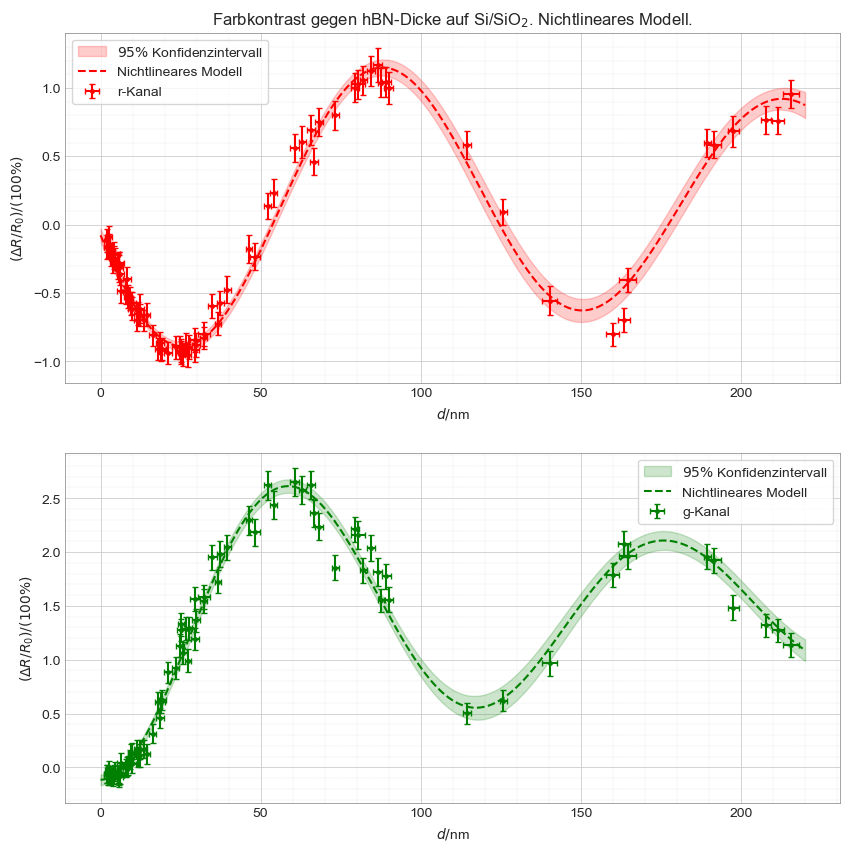

In [15]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i in range(2):
    popt_i = popt[i]
    pcov_i = pcov[i]
    a_i, b_i, c_i, d_i, e_i = unc.correlated_values(popt_i, pcov_i) # for confidence interval
    amp_i = popt_i[0]
    sd_i = popt_i[1]
    lmbd_i = popt_i[2]
    phi0_i = popt_i[3]
    r0_i = popt_i[4]
    py_i = conf_model(xvalues, a_i, b_i, c_i, d_i, e_i)
    nom_i = unp.nominal_values(py_i)
    std_i = unp.std_devs(py_i)
    ax[i].fill_between(xvalues, nom_i-1.96*std_i, nom_i+1.96*std_i, color=colors[i], alpha=0.2, label=r'$95 \%$ Konfidenzintervall')
    ax[i].plot(xvalues, model(popt_i, xvalues), color=colors[i], label='Nichtlineares Modell', ls='--')
    ax[i].errorbar(thickness, drs[i::3], xerr=sd_thickness, yerr=sd_drs[i::3], capsize=2, fmt='o', markersize=2.5, color=colors[i], label=f'{colors[i]}-Kanal', ls='')
    ax[i].set_xlabel(r'$d/$nm')
    ax[i].set_ylabel(r'$(\Delta R/R_0)/(100\%)$')
    ax[i].minorticks_on()
    ax[i].grid(which='minor', ls=':', lw=0.3)
    ax[i].grid(which='major', ls='-', lw=0.6)
    ax[i].legend()

ax[0].set_title(r'Farbkontrast gegen hBN-Dicke auf Si/SiO$_2$. Nichtlineares Modell.')
plt.savefig('./figures_and_images/color_contrast_vs_thickness_nonlinear_model.pdf')
plt.show()

In [8]:
red_params = popt[0]
sd_red_params = np.sqrt(np.diag(pcov[0]))
green_params = popt[1]
sd_green_params = np.sqrt(np.diag(pcov[1]))

print('\nNonlinear fit parameters for R-channel:')
print(f'A = {red_params[0]:.2f}+-{sd_red_params[0]:.2f}')
print(f'sigma = {red_params[1]:.0f}+-{sd_red_params[1]:.0f}')
print(f'lambda_hBN = {red_params[2]:.2f}+-{sd_red_params[2]:.2f}')
print(f'phi0 = {red_params[3]:.2f}+-{sd_red_params[3]:.2f}')
print(f'R0 = {red_params[4]:.2f}+-{sd_red_params[4]:.2f}\n')
print(f'-> lambda_exc = {2*n_hbn(2*2.13262*red_params[2])*red_params[2]:.2f}+-{2*2.2*sd_red_params[2]:.2f}')
print(f'Residual Variance = {resvar[0]}')

print('\nNonlinear fit parameters for G-channel:')
print(f'A = {green_params[0]:.2f}+-{sd_green_params[0]:.2f}')
print(f'sigma = {green_params[1]:.0f}+-{sd_green_params[1]:.0f}')
print(f'lambda_hBN = {green_params[2]:.2f}+-{sd_green_params[2]:.2f}')
print(f'phi0 = {green_params[3]:.2f}+-{sd_green_params[3]:.2f}')
print(f'G0 = {green_params[4]:.2f}+-{sd_green_params[4]:.2f}\n')
print(f'-> lambda_exc = {2*n_hbn(2*2.14718*green_params[2])*green_params[2]:.2f}+-{2*2.2*sd_green_params[2]:.2f}')
print(f'Residual Variance = {resvar[1]}')


Nonlinear fit parameters for R-channel:
A = 1.15+-0.04
sigma = 453+-82
lambda_hBN = 124.85+-1.16
phi0 = -2.90+-0.02
R0 = 0.20+-0.02

-> lambda_exc = 535.95+-5.09
Residual Variance = 0.9205057139870813

Nonlinear fit parameters for G-channel:
A = 1.56+-0.03
sigma = 208+-21
lambda_hBN = 117.28+-1.18
phi0 = -1.66+-0.04
G0 = 1.44+-0.02

-> lambda_exc = 505.90+-5.18
Residual Variance = 1.0442248915298629


In [9]:
x_thickness = np.linspace(0, uplim, 200)
y_thickness = np.linspace(0, uplim, 200)
difference = np.empty((len(x_thickness), len(y_thickness)))
i = 0
for thickness_x in x_thickness:
    tmp = []
    for thickness_y in y_thickness:
        tmp.append(np.sqrt((model(red_params, thickness_x)-model(red_params, thickness_y))**2+(model(green_params, thickness_x)-model(green_params, thickness_y))**2))
    difference[i][:] = tmp[:]
    i+=1

difference = np.where(difference<1, difference, 1)

In [10]:
# x_thickness = np.linspace(0, uplim, 200)
# y_thickness = np.linspace(0, uplim, 200)
# difference = np.empty((len(x_thickness), len(y_thickness)))
# i = 0
# for thickness_x in x_thickness:
#     tmp = []
#     for thickness_y in y_thickness:
#         tmp.append(abs(model(red_params, thickness_x)-model(red_params, thickness_y))+abs(model(green_params, thickness_x)-model(green_params, thickness_y)))
#     difference[i][:] = tmp[:]
#     i+=1
# difference = np.where(difference<1, difference, 1)

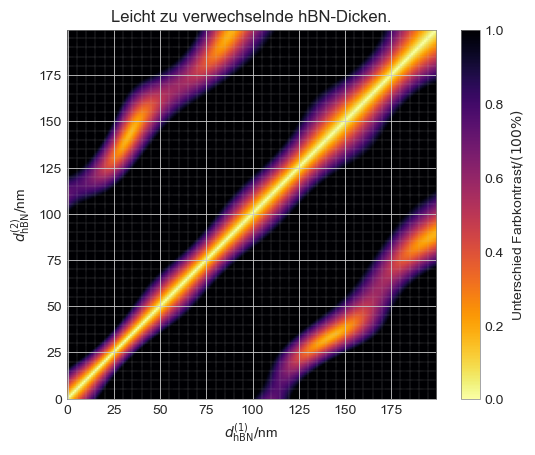

In [14]:
plt.imshow(difference, origin='lower', cmap='inferno_r')
plt.xlabel(r'$d_\mathrm{hBN}^{(1)}/$nm')
plt.ylabel(r'$d_\mathrm{hBN}^{(2)}/$nm')
plt.minorticks_on()
plt.grid(which='minor', ls=':', lw=0.3)
plt.grid(which='major', ls='-', lw=0.6)
plt.title('Leicht zu verwechselnde hBN-Dicken.')
plt.colorbar(label=r'Unterschied Farbkontrast$/(100\%)$')
plt.savefig('./figures_and_images/thicknesses_likeley2be_confused.pdf')
plt.show()

In [12]:
print(difference)

[[0.         0.0611075  0.1212673  ... 1.         1.         1.        ]
 [0.0611075  0.         0.06028565 ... 1.         1.         1.        ]
 [0.1212673  0.06028565 0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.02707069 0.0537382 ]
 [1.         1.         1.         ... 0.02707069 0.         0.02672501]
 [1.         1.         1.         ... 0.0537382  0.02672501 0.        ]]
